In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import re
import spacy

from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.initializers import Constant
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.datasets import make_classification

from tqdm.notebook import tqdm

tqdm().pandas()

pd_ctx = pd.option_context('display.max_colwidth', 100)

0it [00:00, ?it/s]

# Mô tả bài toán
Bài toán đặt ra là phân loại câu hỏi trên quora có chứa nội dung toxic hay không (insincere question)
- Input: Câu hỏi dưới dạng văn bản
- Output: Yes/No

# Công việc cần phải thực hiện
1. Tiền xử lý dữ liệu
2. Tạo và huấn luyện mô hình
3. Sử dụng mô hình để dự đoán

# Overview dữ liệu

In [2]:
# đọc file dữ liệu để train
TRAIN_FILE = '/kaggle/input/quora-insincere-questions-classification/train.csv'
TEST_FILE = '/kaggle/input/quora-insincere-questions-classification/test.csv'
df = pd.read_csv(TRAIN_FILE)
df.info()

test_df = pd.read_csv(TEST_FILE)
with pd_ctx:
    print("Sincere question")
    display(df[df['target'] == 0].head())
    print("Insincere question")
    display(df[df['target'] == 1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
Sincere question


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


Insincere question


,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Repub...,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and ...",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


**Kích thước train.csv:**
* Số dòng: 1.31 millions
* Số cột: 3

**Data field**
+ `qid`: mã số của câu hỏi (question identifier)
+ `quesntion_text`: nội dung của câu hỏi cần phân loại (type: text)
+ `target`: nhãn của câu hỏi, câu chứa nội dung toxic có nhãn là 1, ngược lại là 0 (type: int)

Không có dữ liệu nào bất thường (missing, null)

## Phân lớp của dữ liệu

Total =  1306122
Num of sincere question: 1225312 ( 93.81% )
Num of insincere question: 80810 ( 6.19% )
Ratio = 1516.29 %


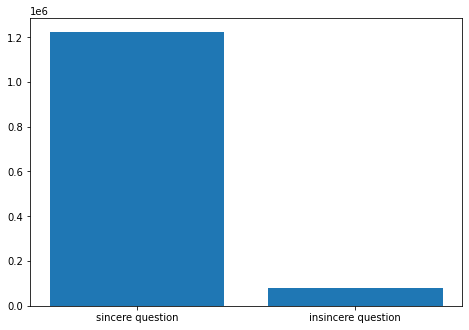

In [3]:
pos_len = len(df[df['target'] == 1])
neg_len = len(df[df['target'] == 0])
total = len(df)
print("Total = ", total)
print("Num of sincere question: {neg} ({percent: .2f}% )".format(neg = neg_len, percent = neg_len / total * 100))
print("Num of insincere question: {pos} ({percent: .2f}% )".format(pos = pos_len, percent = pos_len / total * 100))
print("Ratio = {ratio:.2f} %".format(ratio = neg_len / pos_len  * 100 ))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['sincere question', 'insincere question'], df.target.value_counts())
plt.show()

Dựa vào biểu đồ trên, ta nhận thấy dữ liệu được chia thành 2 class: 0 (sincere question) và 1 (insincere question)

- class 0: 1225312 dữ liệu
- class 1: 80810 dữ liệu

=> Bộ dữ liệu để đào tạo bị mất cân bằng (kết quả negative gấp 15 lần positive)

=> Phải sử dụng `f1_score` để dánh giá mô hình.

# Xử lý dữ liệu

In [4]:
# dữ liệu để huấn luyện
train = df.sample(frac = 1,random_state=123).reset_index(drop=True) # shuffle dữ liệu

# Để demo nhanh, ở đây mình lấy ra 100 mẫu dữ liệu sample
sample = train.sample(n=100, random_state=123)
with pd_ctx:
    display(sample)

,qid,question_text,target
677319,cb304a4facdd58b51c83,What are the difference between 'critical review of a movie' and ' citical review a book'?,0
802133,7e4d6540ebe0b9b50228,Why would an intelligent girl interested in an average guy?,0
357211,3b133b7c626528f9e27d,Will a 1460 in SAT and 1560 in sat subject test witha good essay give me admission at Caltech?,0
165764,8fda4bfd14deeea0cd61,How do doctors who perform euthanasia on their patients harmonise their practice with their oath...,0
441097,e34b913ea70d9105f679,How was the cosmic microwave background discovered or made?,0
...,...,...,...
585732,29109fb3457408af94fb,How do I deal with a cheater if I depend on him financially?,0
823158,9433706c914b1d3a3d7a,How do I stay focused for long time on studies?,0
688032,c9f2c2c6e825f15a9655,Did Leia appreciate the warmth emitted by Jabba's body at night?,0
1256372,114249d6bea154f99abb,Can an international student get an admission in Canada while studying in Norway?,0


Nhận thấy trong câu có chứa các dữ liệu đặc biệt, chữ viết tắt, sai chính tả. Điều này có thể gây ảnh hưởng đến từ điển mà ta xây dựng sau này.

Ví dụ: `I'm` và `I am`, `question?` và `question` (cùng chỉ 1 từ, nhưng khi ta tạo từ điển, sẽ có 2 giá trị)

Do đó ta cần loại bỏ các ký tự đặc biệt, phục hồi dạng đầy đủ của các từ viết tắt phổ biến. Hạn chế tối đa các từ sai chính tả

In [5]:
# Làm sạch câu
contractions={
	"i'm": 'i am',
	"i'm'a": 'i am about to',
	"i'm'o": 'i am going to',
	"i've": 'i have',
	"i'll": 'i will',
	"i'll've": 'i will have',
	"i'd": 'i would',
	"i'd've": 'i would have',
	"Whatcha": 'What are you',
	"amn't": 'am not',
	"ain't": 'are not',
	"aren't": 'are not',
	"'cause": 'because',
	"can't": 'can not',
	"can't've": 'can not have',
	"could've": 'could have',
	"couldn't": 'could not',
	"couldn't've": 'could not have',
	"daren't": 'dare not',
	"daresn't": 'dare not',
	"dasn't": 'dare not',
	"didn't": 'did not',
	'didn’t': 'did not',
	"don't": 'do not',
	'don’t': 'do not',
	"doesn't": 'does not',
	"e'er": 'ever',
	"everyone's": 'everyone is',
	"finna": 'fixing to',
	"gimme": 'give me',
	"gon't": 'go not',
	"gonna": 'going to',
	"gotta": 'got to',
	"hadn't": 'had not',
	"hadn't've": 'had not have',
	"hasn't": 'has not',
	"haven't": 'have not',
	"he've": 'he have',
	"he's": 'he is',
	"he'll": 'he will',
	"he'll've": 'he will have',
	"he'd": 'he would',
	"he'd've": 'he would have',
	"here's": 'here is',
	"how're": 'how are',
	"how'd": 'how did',
	"how'd'y": 'how do you',
	"how's": 'how is',
	"how'll": 'how will',
	"isn't": 'is not',
	"it's": 'it is',
	"'tis": 'it is',
	"'twas": 'it was',
	"it'll": 'it will',
	"it'll've": 'it will have',
	"it'd": 'it would',
	"it'd've": 'it would have',
	"kinda": 'kind of',
	"let's": 'let us',
	"luv": 'love',
	"ma'am": 'madam',
	"may've": 'may have',
	"mayn't": 'may not',
	"might've": 'might have',
	"mightn't": 'might not',
	"mightn't've": 'might not have',
	"must've": 'must have',
	"mustn't": 'must not',
	"mustn't've": 'must not have',
	"needn't": 'need not',
	"needn't've": 'need not have',
	"ne'er": 'never',
	"o'": 'of',
	"o'clock": 'of the clock',
	"ol'": 'old',
	"oughtn't": 'ought not',
	"oughtn't've": 'ought not have',
	"o'er": 'over',
	"shan't": 'shall not',
	"sha'n't": 'shall not',
	"shalln't": 'shall not',
	"shan't've": 'shall not have',
	"she's": 'she is',
	"she'll": 'she will',
	"she'd": 'she would',
	"she'd've": 'she would have',
	"should've": 'should have',
	"shouldn't": 'should not',
	"shouldn't've": 'should not have',
	"so've": 'so have',
	"so's": 'so is',
	"somebody's": 'somebody is',
	"someone's": 'someone is',
	"something's": 'something is',
	"sux": 'sucks',
	"that're": 'that are',
	"that's": 'that is',
	"that'll": 'that will',
	"that'd": 'that would',
	"that'd've": 'that would have',
	"em": 'them',
	"there're": 'there are',
	"there's": 'there is',
	"there'll": 'there will',
	"there'd": 'there would',
	"there'd've": 'there would have',
	"these're": 'these are',
	"they're": 'they are',
	"they've": 'they have',
	"they'll": 'they will',
	"they'll've": 'they will have',
	"they'd": 'they would',
	"they'd've": 'they would have',
	"this's": 'this is',
	"those're": 'those are',
	"to've": 'to have',
	"wanna": 'want to',
	"wasn't": 'was not',
	"we're": 'we are',
	"we've": 'we have',
	"we'll": 'we will',
	"we'll've": 'we will have',
	"we'd": 'we would',
	"we'd've": 'we would have',
	"weren't": 'were not',
	"what're": 'what are',
	"what'd": 'what did',
	"what've": 'what have',
	"what's": 'what is',
	"what'll": 'what will',
	"what'll've": 'what will have',
	"when've": 'when have',
	"when's": 'when is',
	"where're": 'where are',
	"where'd": 'where did',
	"where've": 'where have',
	"where's": 'where is',
	"which's": 'which is',
	"who're": 'who are',
	"who've": 'who have',
	"who's": 'who is',
	"who'll": 'who will',
	"who'll've": 'who will have',
	"who'd": 'who would',
	"who'd've": 'who would have',
	"why're": 'why are',
	"why'd": 'why did',
	"why've": 'why have',
	"why's": 'why is',
	"will've": 'will have',
	"won't": 'will not',
	"won't've": 'will not have',
	"would've": 'would have',
	"wouldn't": 'would not',
	"wouldn't've": 'would not have',
	"y'all": 'you all',
	"y'all're": 'you all are',
	"y'all've": 'you all have',
	"y'all'd": 'you all would',
	"y'all'd've": 'you all would have',
	"you're": 'you are',
	"you've": 'you have',
	"you'll've": 'you shall have',
	"you'll": 'you will',
	"you'd": 'you would',
	"you'd've": 'you would have',
	'jan.': 'january',
	'feb.': 'february',
	'mar.': 'march',
	'apr.': 'april',
	'jun.': 'june',
	'jul.': 'july',
	'aug.': 'august',
	'sep.': 'september',
	'oct.': 'october',
	'nov.': 'november',
	'dec.': 'december',
	'I’m': 'I am',
	'I’m’a': 'I am about to',
	'I’m’o': 'I am going to',
	'I’ve': 'I have',
	'I’ll': 'I will',
	'I’ll’ve': 'I will have',
	'I’d': 'I would',
	'I’d’ve': 'I would have',
	'amn’t': 'am not',
	'ain’t': 'are not',
	'aren’t': 'are not',
	'’cause': 'because',
	'can’t': 'can not',
	'can’t’ve': 'can not have',
	'could’ve': 'could have',
	'couldn’t': 'could not',
	'couldn’t’ve': 'could not have',
	'daren’t': 'dare not',
	'daresn’t': 'dare not',
	'dasn’t': 'dare not',
	'doesn’t': 'does not',
	'e’er': 'ever',
	'everyone’s': 'everyone is',
	'gon’t': 'go not',
	'hadn’t': 'had not',
	'hadn’t’ve': 'had not have',
	'hasn’t': 'has not',
	'haven’t': 'have not',
	'he’ve': 'he have',
	'he’s': 'he is',
	'he’ll': 'he will',
	'he’ll’ve': 'he will have',
	'he’d': 'he would',
	'he’d’ve': 'he would have',
	'here’s': 'here is',
	'how’re': 'how are',
	'how’d': 'how did',
	'how’d’y': 'how do you',
	'how’s': 'how is',
	'how’ll': 'how will',
	'isn’t': 'is not',
	'it’s': 'it is',
	'’tis': 'it is',
	'’twas': 'it was',
	'it’ll': 'it will',
	'it’ll’ve': 'it will have',
	'it’d': 'it would',
	'it’d’ve': 'it would have',
	'let’s': 'let us',
	'ma’am': 'madam',
	'may’ve': 'may have',
	'mayn’t': 'may not',
	'might’ve': 'might have',
	'mightn’t': 'might not',
	'mightn’t’ve': 'might not have',
	'must’ve': 'must have',
	'mustn’t': 'must not',
	'mustn’t’ve': 'must not have',
	'needn’t': 'need not',
	'needn’t’ve': 'need not have',
	'ne’er': 'never',
	'o’': 'of',
	'o’clock': 'of the clock',
	'ol’': 'old',
	'oughtn’t': 'ought not',
	'oughtn’t’ve': 'ought not have',
	'o’er': 'over',
	'shan’t': 'shall not',
	'sha’n’t': 'shall not',
	'shalln’t': 'shall not',
	'shan’t’ve': 'shall not have',
	'she’s': 'she is',
	'she’ll': 'she will',
	'she’d': 'she would',
	'she’d’ve': 'she would have',
	'should’ve': 'should have',
	'shouldn’t': 'should not',
	'shouldn’t’ve': 'should not have',
	'so’ve': 'so have',
	'so’s': 'so is',
	'somebody’s': 'somebody is',
	'someone’s': 'someone is',
	'something’s': 'something is',
	'that’re': 'that are',
	'that’s': 'that is',
	'that’ll': 'that will',
	'that’d': 'that would',
	'that’d’ve': 'that would have',
	'there’re': 'there are',
	'there’s': 'there is',
	'there’ll': 'there will',
	'there’d': 'there would',
	'there’d’ve': 'there would have',
	'these’re': 'these are',
	'they’re': 'they are',
	'they’ve': 'they have',
	'they’ll': 'they will',
	'they’ll’ve': 'they will have',
	'they’d': 'they would',
	'they’d’ve': 'they would have',
	'this’s': 'this is',
	'those’re': 'those are',
	'to’ve': 'to have',
	'wasn’t': 'was not',
	'we’re': 'we are',
	'we’ve': 'we have',
	'we’ll': 'we will',
	'we’ll’ve': 'we will have',
	'we’d': 'we would',
	'we’d’ve': 'we would have',
	'weren’t': 'were not',
	'what’re': 'what are',
	'what’d': 'what did',
	'what’ve': 'what have',
	'what’s': 'what is',
	'what’ll': 'what will',
	'what’ll’ve': 'what will have',
	'when’ve': 'when have',
	'when’s': 'when is',
	'where’re': 'where are',
	'where’d': 'where did',
	'where’ve': 'where have',
	'where’s': 'where is',
	'which’s': 'which is',
	'who’re': 'who are',
	'who’ve': 'who have',
	'who’s': 'who is',
	'who’ll': 'who will',
	'who’ll’ve': 'who will have',
	'who’d': 'who would',
	'who’d’ve': 'who would have',
	'why’re': 'why are',
	'why’d': 'why did',
	'why’ve': 'why have',
	'why’s': 'why is',
	'will’ve': 'will have',
	'won’t': 'will not',
	'won’t’ve': 'will not have',
	'would’ve': 'would have',
	'wouldn’t': 'would not',
	'wouldn’t’ve': 'would not have',
	'y’all': 'you all',
	'y’all’re': 'you all are',
	'y’all’ve': 'you all have',
	'y’all’d': 'you all would',
	'y’all’d’ve': 'you all would have',
	'you’re': 'you are',
	'you’ve': 'you have',
	'you’ll’ve': 'you shall have',
	'you’ll': 'you will',
	'you’d': 'you would',
	'you’d’ve': 'you would have',
}

def contraction_fix(word):
    try:
        a=contractions[word]
    except KeyError:
        a=word
    return a

def clean_text(text):
    text = text.lower()
    text = " ".join([contraction_fix(w) for w in text.split()]) # sửa từ viết tắt
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) # Loại bỏ các ký tự không phải chữ và số
    return text

def apply_clean_text(question_text):
    tmp = pd.DataFrame()
    tmp['question_text'] = question_text;
    tmp['clean'] = tmp.question_text.progress_map(clean_text)
    with pd_ctx:
        display(tmp)
    return tmp['clean']
        
sample['clean'] = apply_clean_text(sample.question_text)

  0%|          | 0/100 [00:00<?, ?it/s]

,question_text,clean
677319,What are the difference between 'critical review of a movie' and ' citical review a book'?,what are the difference between critical review of a movie and citical review a book
802133,Why would an intelligent girl interested in an average guy?,why would an intelligent girl interested in an average guy
357211,Will a 1460 in SAT and 1560 in sat subject test witha good essay give me admission at Caltech?,will a 1460 in sat and 1560 in sat subject test witha good essay give me admission at caltech
165764,How do doctors who perform euthanasia on their patients harmonise their practice with their oath...,how do doctors who perform euthanasia on their patients harmonise their practice with their oath...
441097,How was the cosmic microwave background discovered or made?,how was the cosmic microwave background discovered or made
...,...,...
585732,How do I deal with a cheater if I depend on him financially?,how do i deal with a cheater if i depend on him financially
823158,How do I stay focused for long time on studies?,how do i stay focused for long time on studies
688032,Did Leia appreciate the warmth emitted by Jabba's body at night?,did leia appreciate the warmth emitted by jabba s body at night
1256372,Can an international student get an admission in Canada while studying in Norway?,can an international student get an admission in canada while studying in norway


## Mã hóa cột văn bản và chuyển đổi chúng thành vectơ

Do trường `question_text` là dạng văn bản, nên để dễ huấn luyện ta cần mã hóa để chuyển thành vecto của các số nguyên.

Ở đây mình sử dụng `Tokenizer` của thư viện `keras`

### Tạo từ điển

In [6]:
OOV_TOKEN = '<OOV>' # out of vocab token: thay thế các từ không có trong từ điển thành từ mà ta chọn
def create_tokenizer(docs):
    tokenizer = Tokenizer(oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(list(docs))
    print("Size of vocabulary: ", len(tokenizer.word_index))
    return tokenizer
tokenizer = create_tokenizer(sample['clean'])

Size of vocabulary:  629


`word_index` là `dict` chứa ánh xạ của 1 từ sang index của nó

index càng nhỏ => tần suất xuất hiện càng nhiều

In [7]:
print(tokenizer.word_index)

{'<OOV>': 1, 'the': 2, 'what': 3, 'is': 4, 'a': 5, 'to': 6, 'and': 7, 'how': 8, 'of': 9, 'in': 10, 'for': 11, 'i': 12, 'do': 13, 'are': 14, 'it': 15, 'you': 16, 'why': 17, 'be': 18, 'can': 19, 'my': 20, 's': 21, 'an': 22, 'good': 23, 'at': 24, 'on': 25, 'which': 26, 'being': 27, 'should': 28, 'between': 29, 'would': 30, 'from': 31, 'like': 32, 'about': 33, 'does': 34, 'me': 35, 'was': 36, 'or': 37, 'best': 38, 'years': 39, 'have': 40, 'if': 41, 'did': 42, 'time': 43, 'has': 44, 'one': 45, 'people': 46, 'difference': 47, 'average': 48, 'will': 49, 'their': 50, 'with': 51, 'first': 52, 'some': 53, 'his': 54, 'many': 55, 'year': 56, 'am': 57, '20': 58, 'old': 59, 'she': 60, 'indian': 61, 'where': 62, 'countries': 63, 'not': 64, 'earth': 65, 'college': 66, 'three': 67, 'as': 68, 'your': 69, 'they': 70, 'feel': 71, 'girlfriend': 72, 'x': 73, 'make': 74, 'liberal': 75, 'b': 76, 'review': 77, 'movie': 78, 'girl': 79, 'sat': 80, 'give': 81, 'admission': 82, 'turn': 83, 'states': 84, 'more': 85

### Sử dụng từ điển chuyển text thành vector

In [8]:
word_sequences = tokenizer.texts_to_sequences(sample['clean'])
# Độ dài của mỗi chuỗi
print("Length of 20 first word_sequences:")
print(list(map(lambda x: len(x) ,word_sequences[:20])))

print("\n20 first word_sequences:")
for sequence in word_sequences[:20]:
    print(sequence)

Length of 20 first word_sequences:
[15, 10, 19, 19, 9, 16, 12, 25, 17, 14, 10, 17, 25, 13, 3, 11, 11, 27, 7, 5]

20 first word_sequences:
[3, 14, 2, 47, 29, 143, 77, 9, 5, 78, 7, 144, 77, 5, 145]
[17, 30, 22, 146, 79, 147, 10, 22, 48, 148]
[49, 5, 149, 10, 80, 7, 150, 10, 80, 151, 152, 153, 23, 154, 81, 35, 82, 24, 155]
[8, 13, 156, 157, 158, 159, 25, 50, 160, 161, 50, 162, 51, 50, 163, 52, 13, 164, 165]
[8, 36, 2, 166, 167, 168, 169, 37, 170]
[3, 4, 2, 171, 29, 172, 173, 7, 174, 175, 9, 22, 176, 11, 177, 83]
[178, 4, 2, 179, 180, 9, 181, 182, 183, 11, 5, 184]
[26, 185, 186, 36, 2, 187, 9, 188, 10, 189, 190, 84, 9, 191, 24, 2, 83, 9, 2, 192, 193, 85, 194, 195, 196]
[86, 42, 197, 198, 199, 200, 201, 11, 2, 52, 43, 7, 3, 36, 202, 9, 203]
[3, 4, 2, 47, 29, 2, 204, 205, 87, 7, 206, 88, 207, 87]
[3, 4, 2, 208, 29, 27, 209, 7, 27, 210]
[14, 211, 212, 213, 6, 18, 214, 215, 89, 3, 14, 2, 38, 90, 6, 13, 15]
[19, 16, 81, 53, 216, 11, 91, 217, 54, 218, 92, 219, 31, 54, 220, 11, 2, 52, 43, 8, 19, 

Độ dài của mỗi chuỗi không bằng nhau (chuỗi dài, chuỗi ngắn) => sẽ gây khó khắn cho quá trình huấn luyện mô hình

Ta chuẩn hóa tất cả các input về cùng một độ dài cố định bằng ký thuật padding và truncating 

- `padding`: nếu chuỗi bị ngắn thì thực hiện padding bằng các thêm 0 vào đăng sau chuỗi.
    
- `truncating`: nếu chuỗi bị dài thì ta làm ngắn bằng cách bỏ đi phần dư ra ở cuối chuỗi.



In [9]:
MAX_SENTENCE_LENGTH = 100 # Độ dài tối đa của chuỗi
PADDING_TYPE = 'post' # kiểu padding, post = cuối chuỗi
TRUNCATE_TYPE = 'post'# kiểu truncating, post = cuối chuỗi
def create_sequence(tokenizer, docs):
    word_sequeces = tokenizer.texts_to_sequences(docs)
    padded_word_sequences = pad_sequences(word_sequeces, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
    return padded_word_sequences
padded_sequences = create_sequence(tokenizer, sample['clean'])

    
# Độ dài của mỗi chuỗi
print("Length of 10 first word_sequences:")
print(list(map(lambda x: len(x) ,padded_sequences[:10])))

print("\n10 first word_sequences:")
for sequence in padded_sequences[:10]:
    print(sequence)


Length of 10 first word_sequences:
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

10 first word_sequences:
[  3  14   2  47  29 143  77   9   5  78   7 144  77   5 145   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[ 17  30  22 146  79 147  10  22  48 148   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[ 49   5 149  10  80   7 150  10  80 151 152 153  23 154  81  35  82  24
 

Sau bước này, độ dài của tất cả các chuỗi đều bằng nhau (len = 100)

### Build model

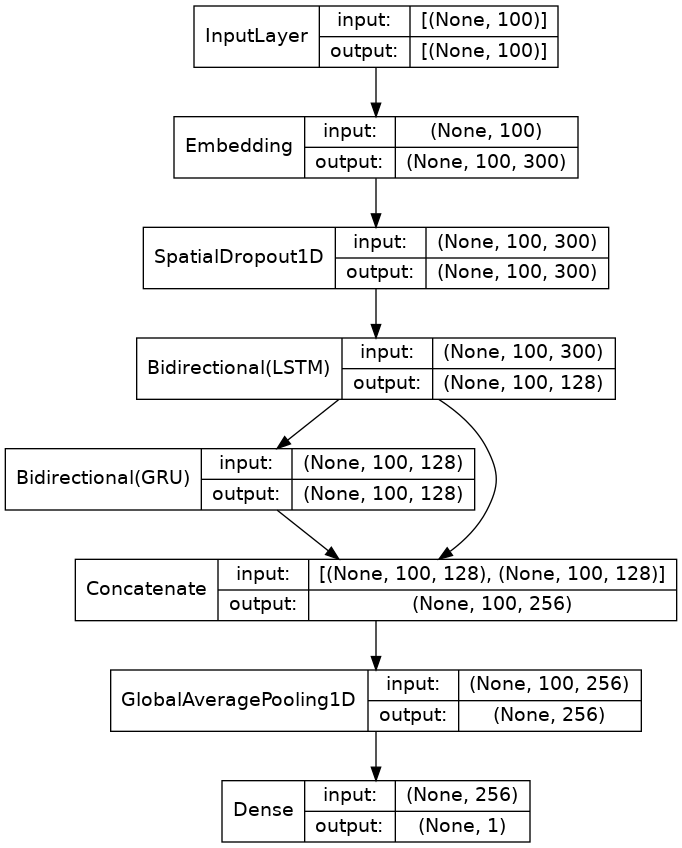

Embedding: Do số lượng đặc trưng (từ trong từ điển) là khá lớn, do đó sử dùng layer Embedding để giảm số chiều của không gian đặc trưng. Cụ thể là mỗi từ sẽ được biểu diễn bằng một vecto có số chiều xác định. 

SpatialDropout1D: hạn chế overfitting (mỗi bước khi train model thì ngẫu nhiên (1-p%) các node bị loại bỏ nên model không thể phụ thuộc vào bất kì node nào của layer trước mà thay vào đó có xu hướng trải đều weight)

Bidirectional LSTM và GRU: 2 layer này để xử lý thông tin dạng chuỗi





In [46]:
EMBEDDING_DIM = 300
def createModel_bidirectional_LSTM_GRU(features,embedding_matrix = None, units = 64):
    output_bias = Constant(np.log([pos_len/neg_len])) # Khởi tạo gia trị đầu cho bias
    
    x_input = Input(shape=(MAX_SENTENCE_LENGTH))
    if not(embedding_matrix is None):
        embedding = Embedding(features, EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH, weights=[embedding_matrix])(x_input)
    else:
        embedding = Embedding(features, EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH)(x_input)
    x = SpatialDropout1D(0.2)(embedding)
    
    lstm = Bidirectional(LSTM(units, return_sequences=True))(x)
    gru = Bidirectional(GRU(units, return_sequences=True))(lstm)
    
    x = Concatenate()([lstm, gru])
    x = GlobalAveragePooling1D()(x)
    
    x_output = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    
    model = Model(inputs=x_input, outputs=x_output)
    opt = Adam()
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=[f1_m])
    return model


# Sử dụng hàm này để tính f1_score trong khi train model
# không biết vì sao e dùng metrics.f1_score lại bị lỗi :(
def f1_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Train model



In [11]:
# tạo strategy sử dụng TPU để train model => tăng tốc độ train
strategy = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


Chọn epochs = 5 là hợp lí. Thử nghiệm với chọn lớn hơn thì mô hình càng ngày càng bị overfitting (loss trên phần trên giảm, trong khi trên tập validate thì càng ngày càng tăng nhiều)

In [48]:
batch_size = 1024
n_epochs = 5
def train_model_and_predict(X_train, y_train, X_val, y_val, X_test, embedding_vec=None):
    
    # Đối với kỹ thuật kfold, để các fold không phụ thuộc vào nhau thì ta phải tạo lại từ điển (tokenizer)
    # Sau đó chuyển các câu thành sequence theo word_index của từ điển mới.
    
    # tokenize and convert to sequence
    print("Create vocab...")
    tokenizer = create_tokenizer(X_train)
    print("Create sequences...")
    X_train_seq = create_sequence(tokenizer, X_train)
    X_val_seq = create_sequence(tokenizer, X_val)
    X_test_seq = create_sequence(tokenizer, X_test)
    
    embedding_matrix = None
    if not(embedding_vec is None):
        embedding_matrix = load_embedding(embedding_vec, tokenizer.word_index)
    
    # build model and training
    model = createModel_bidirectional_LSTM_GRU(len(tokenizer.word_index)+1, embedding_matrix)
    model.fit(X_train_seq, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val_seq, y_val))
    
    # get f1_score, threshold
    val_pred = model.predict(X_val_seq, verbose=1, batch_size=2048)
    threshold, f1_score = best_threshold(y_val, val_pred)
    
    test_pred = model.predict(X_test_seq, verbose=1, batch_size=2048)
    
    return threshold, f1_score, val_pred, test_pred

**Threshold**

Bình thường, đối với phân lớp nhị phân kết quả dự đoán sẽ thuộc (0,1), threshold = 0.5 .

Nếu threshold < 0.5 thì phân lớp là negative, ngược lại thì là positive

Nhưng trong một số trường hợp, giá trị 0.5 này có thể chưa phải là tốt nhất. 

Do đó, ta thử điều chỉnh giá trị threshold này để tìm ra giá trị nào mà cho f1_score là tốt nhất => best_threshold

In [13]:
def best_threshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.9, 0.01)):
        tmp[1] = metrics.f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta, tmp[2] # threshold, f1_score

In [14]:
# Thực hiện làm sạch cho dữ liêu huấn luyện và dữ liêu test để chuẩn bị qua quá trình train
trainY = train.target

print("Clean train question")
trainX_text = apply_clean_text(train.question_text)
print("Clean test question")
testX_text = apply_clean_text(test_df.question_text)

Clean train question


  0%|          | 0/1306122 [00:00<?, ?it/s]

,question_text,clean
0,Why do people tend to answer a question with a question?,why do people tend to answer a question with a question
1,"If I add excess magnesium to aqueous potassium sulphate, will magnesium react with all the water...",if i add excess magnesium to aqueous potassium sulphate will magnesium react with all the water...
2,What is the least and max possible sentence for having a warrant for cutting off an ankle monito...,what is the least and max possible sentence for having a warrant for cutting off an ankle monito...
3,"What are the job options for intellectuals, physicists, science writers etc.?",what are the job options for intellectuals physicists science writers etc
4,How do I make it into St. Stephens College DU for BA (hons) in economics? I am from CBSE and a C...,how do i make it into st stephens college du for ba hons in economics i am from cbse and a c...
...,...,...
1306117,How do I know if I'm an INFP or ENFP?,how do i know if i am an infp or enfp
1306118,"Are Cuckoos Calling, Silkworm and Career of Evil good books?",are cuckoos calling silkworm and career of evil good books
1306119,What is the South African Army about?,what is the south african army about
1306120,How much scholarship we get in entrance test?,how much scholarship we get in entrance test


Clean test question


  0%|          | 0/375806 [00:00<?, ?it/s]

,question_text,clean
0,Why do so many women become so rude and arrogant when they get just a little bit of wealth and p...,why do so many women become so rude and arrogant when they get just a little bit of wealth and p...
1,When should I apply for RV college of engineering and BMS college of engineering? Should I wait ...,when should i apply for rv college of engineering and bms college of engineering should i wait ...
2,What is it really like to be a nurse practitioner?,what is it really like to be a nurse practitioner
3,Who are entrepreneurs?,who are entrepreneurs
4,Is education really making good people nowadays?,is education really making good people nowadays
...,...,...
375801,How many countries listed in gold import in indua?,how many countries listed in gold import in indua
375802,Is there an alternative to dresses on formal parties?,is there an alternative to dresses on formal parties
375803,Where I can find best friendship quotes in Telugu?,where i can find best friendship quotes in telugu
375804,What are the causes of refraction of light?,what are the causes of refraction of light


## Train model without Pretrained Embeddings
Thử nghiệm với mô hình với lớp embedding sẽ không sử dụng bất kì pretrain word embeddings nào (mô hình học lại từ đầu)

Sử dụng xác thực chéo (KFold cross validation) giúp chúng ta đánh giá model đầy đủ và chính xác hơn

KFold cross validation sẽ chia bộ dữ liệu thành k phần bằng nhau. Với StratifiedKFold, ta chỉ xáo trộn dữ liệu 1 lần, rồi chia thành các phần có phân phối với mỗi class bằng với dữ liệu ban đầu

Sau đó train model K lần, mỗi lần train sẽ chọn 1 phần làm dữ liệu validation và K-1 phần còn lại làm dữ liệu training. 

Kết quả đánh giá model cuối cùng sẽ là trung bình cộng kết quả đánh giá của K lần train

In [18]:
def kfold_cv(trainX_text, trainY, testX_text, embedding_vec=None, n_folds = 5):
    with strategy.scope():
    # prepare cross validation
        kfold = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=123)

        thresholds = [] # theshold từng fold
        scores = [] # f1_score từng fold
        prediction_va = np.zeros(len(trainX_text)) # tổng hợp kết quả của k fold , dự doán phần validation
        prediction_te = np.zeros(len(testX_text)) # tổng hợp kết quả của k fold , dự doán phần test
        # enumerate splits
        idx = 0
        for train_id, val_id in kfold.split(trainX_text, trainY):
            print("Fold ", idx)
            X_train_text, y_train  = trainX_text[train_id], trainY[train_id]
            X_val_text, y_val = trainX_text[val_id], trainY[val_id]
            # train and predict
            threshold, f1_score, val_pred, test_pred = train_model_and_predict(X_train_text, y_train, X_val_text, y_val, testX_text, embedding_vec)

            # save
            prediction_va[val_id] = np.squeeze(val_pred)
            thresholds.append(threshold)
            scores.append(f1_score)

            prediction_te = prediction_te + (1 / n_folds) * np.squeeze(test_pred)
            idx = idx+1
        return prediction_va, prediction_te, thresholds, scores

In [19]:
prediction_va, prediction_te, thresholds, scores = kfold_cv(trainX_text, trainY, testX_text, n_folds=5)

Fold  0
Create vocab...
Size of vocabulary:  171324
Create sequences...
Epoch 1/5
1021/1021 [==============================] - 88s 75ms/step - loss: 0.1486 - f1_m: 0.3791 - val_loss: 0.1136 - val_f1_m: 0.6135
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0999 - f1_m: 0.6257 - val_loss: 0.1089 - val_f1_m: 0.5639
Epoch 3/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0854 - f1_m: 0.6846 - val_loss: 0.1148 - val_f1_m: 0.5963
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0729 - f1_m: 0.7373 - val_loss: 0.1221 - val_f1_m: 0.5958
Epoch 5/5
128/128 [==============================] - 5s 29ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3400 with F1 score: 0.6200
184/184 [==============================] - 4s 19ms/step
Fold  1
Create vocab...
Size of vocabulary:  171217
Create sequences...
Epoch 1/5
1021/1021 [==============================] - 88s 75ms/step - loss: 0.1478 - f1_m: 0.3668 - val_loss: 0.1096 - val_f1_m: 0.5937
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.1000 - f1_m: 0.6187 - val_loss: 0.1072 - val_f1_m: 0.5907
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0855 - f1_m: 0.6891 - val_loss: 0.1119 - val_f1_m: 0.5970
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0711 - f1_m: 0.7495 - val_loss: 0.1238 - val_f1_m: 0.5956
Epoch 5/5
128/128 [==============================] - 5s 29ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3200 with F1 score: 0.6143
184/184 [==============================] - 4s 19ms/step
Fold  2
Create vocab...
Size of vocabulary:  171455
Create sequences...
Epoch 1/5
1021/1021 [==============================] - 89s 75ms/step - loss: 0.1465 - f1_m: 0.3927 - val_loss: 0.1105 - val_f1_m: 0.5629
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.1002 - f1_m: 0.6206 - val_loss: 0.1103 - val_f1_m: 0.6024
Epoch 3/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0864 - f1_m: 0.6814 - val_loss: 0.1133 - val_f1_m: 0.5899
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0725 - f1_m: 0.7411 - val_loss: 0.1208 - val_f1_m: 0.5899
Epoch 5/5
128/128 [==============================] - 5s 29ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3300 with F1 score: 0.6162
184/184 [==============================] - 4s 18ms/step
Fold  3
Create vocab...
Size of vocabulary:  171067
Create sequences...
Epoch 1/5
1021/1021 [==============================] - 88s 75ms/step - loss: 0.1476 - f1_m: 0.3895 - val_loss: 0.1105 - val_f1_m: 0.5524
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0998 - f1_m: 0.6220 - val_loss: 0.1086 - val_f1_m: 0.6008
Epoch 3/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0845 - f1_m: 0.6875 - val_loss: 0.1132 - val_f1_m: 0.6058
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0710 - f1_m: 0.7500 - val_loss: 0.1257 - val_f1_m: 0.5577
Epoch 5/5
128/128 [==============================] - 5s 29ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3500 with F1 score: 0.6165
184/184 [==============================] - 4s 19ms/step
Fold  4
Create vocab...
Size of vocabulary:  171158
Create sequences...
Epoch 1/5
1021/1021 [==============================] - 89s 75ms/step - loss: 0.1456 - f1_m: 0.3668 - val_loss: 0.1115 - val_f1_m: 0.5808
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.1000 - f1_m: 0.6158 - val_loss: 0.1102 - val_f1_m: 0.6078
Epoch 3/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0846 - f1_m: 0.6886 - val_loss: 0.1161 - val_f1_m: 0.6020
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0716 - f1_m: 0.7464 - val_loss: 0.1223 - val_f1_m: 0.5900
Epoch 5/5
128/128 [==============================] - 5s 29ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3200 with F1 score: 0.6137
184/184 [==============================] - 4s 19ms/step


In [23]:
threshold_on_validation, f1_on_validation = best_threshold(trainY, prediction_va)
for i in range(len(scores)):
    print("Fold {i}: f1_score = {f1_score:.4f} at threshold = {th:.2f}".format(i=i, f1_score=scores[i], th=thresholds[i]))


print("\nGlobal f1_score = {f1_score:.4f} at threshold = {th:.2f}".format(th=threshold_on_validation, f1_score=f1_on_validation))

print(metrics.classification_report(trainY, (prediction_va>threshold_on_validation).astype(int)))

  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3400 with F1 score: 0.6157
Fold 0: f1_score = 0.6200 at threshold = 0.34
Fold 1: f1_score = 0.6143 at threshold = 0.32
Fold 2: f1_score = 0.6162 at threshold = 0.33
Fold 3: f1_score = 0.6165 at threshold = 0.35
Fold 4: f1_score = 0.6137 at threshold = 0.32

Global f1_score = 0.6157 at threshold = 0.34
              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1225312
           1       0.57      0.67      0.62     80810

    accuracy                           0.95   1306122
   macro avg       0.77      0.82      0.79   1306122
weighted avg       0.95      0.95      0.95   1306122



Mô hình đã nhận diện được hầu hết các câu negative.

Đối với positive thì f1-score chỉ được 0.62

## Train model with Pretrained Embeddings
Thử nghiệm với mô hình kết hợp các word embeddings được pretained

### Đọc file embeddings

Các file embedding có dạng text, mỗi dòng chứa 1 word và kèm sau đó là 1 vector tương ứng

Ta cần lấy các word có trong từ điển kèm với vecto tương ứng để tạo thành 1 dict để có thể tra cứu nhanh



In [24]:
# tách từ và vecto tương ứng với nó
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
# lấy số dòng của file embeddings 
def get_lines_count(file_name): 
    return sum(1 for _ in open(file_name, encoding="utf8", errors='ignore'))
# chuyển file embeddigns thành dict
def load_vec(file_name): 
    return dict(
        get_coefs(*o.split(" ")) 
            for o in tqdm(open(
                file_name, encoding="utf8", errors='ignore'), 
                total=get_lines_count(file_name)
            ) if len(o) > 100
    )

Ta cần tạo một mảng chưa weight của các từ tương ứng với `tokenizer.word_index`

Nhận thấy các từ trong từ điển có khả năng không dó trong word embeddings. 

=> Để hiệu quả nhất thì với mỗi từ mà ta không tìm thấy trong word embeddings thì ta sẽ thử biến đổi từ sao cho tìm được vecto gần nó nhất. Bởi vì như vậy chắc chắn sẽ tốt hơn là không có thông tin gì

Để biến đổi từ thì ta sẽ sử dụng một số ký thuật `Stemming`

Chiến thuật là tìm được càng nhiều từ càng tốt



In [53]:
EMBEDDING_DIM = 300 # chọn số chiều của vecto embedding là 300

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

def load_embedding(word2vec, word2index):
    oov_count = 0 # Số lượng từ không tìm thấy vecto embeddings
    vocab_count = 0 # Số lượng từ có vecto embeddings
    vocab_size = len(word2index)
    
    embedding_weights = np.zeros((vocab_size+1, EMBEDDING_DIM)) # khởi tạo trọng số weight = 0
    unknown_vector = np.zeros((EMBEDDING_DIM,), dtype=np.float32) - 1
    unknown_words = {}

    # Tìm kiếm từng từ trong embeddings, nếu không thấy thì lần lượt thực hiện các kỹ thuật biến đổi từ để tìm ra từ gần nghĩa.
    # => hi vọng embeddings cho trước phủ được càng nhiều từ càng tốt.
    for key, i in tqdm(word2index.items()):
        word = key
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        # PorterStemmer ("python","pythoner","pythoning","pythoned" => "python")
        word = ps.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
        
        # LancasterStemmer
        word = lc.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
            
        # SnowballStemmer (connection, connections, connective, connected, and connecting => connect)
        word = sb.stem(key)        
        if word in word2vec:
            embedding_weights[i] = word2vec[word]
            continue
            
        try:
            unknown_words[key] += 1
        except KeyError:
            unknown_words[key] = 1
            
        embedding_weights[i] = unknown_vector

    print('Top 10 Null word embeddings: ')
    print(list(unknown_words.items())[:10])
    print('\nNull word embeddings: %d' % np.sum(np.sum(embedding_weights, axis=1) == -1 * EMBEDDING_DIM))
    
    return embedding_weights

**1. Glove embeddings**

In [26]:
GLOVE_FILE = 'glove.840B.300d/glove.840B.300d.txt'
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {GLOVE_FILE} -d .

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./glove.840B.300d/glove.840B.300d.txt  


In [27]:
print('loading glove_vec')
glove_vec = load_vec(GLOVE_FILE)

loading glove_vec


  0%|          | 0/2196017 [00:00<?, ?it/s]

In [54]:
glove_prediction_va, glove_prediction_te, glove_thresholds, glove_f1_scores = kfold_cv(trainX_text, trainY, testX_text, glove_vec)

Fold  0
Create vocab...
Size of vocabulary:  171324
Create sequences...


  0%|          | 0/171324 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('<OOV>', 1), ('brexit', 1), ('cryptocurrencies', 1), ('redmi', 1), ('kvpy', 1), ('paytm', 1), ('ethereum', 1), ('iisc', 1), ('jinping', 1), ('nmims', 1)]

Null word embeddings: 46471
Epoch 1/5
1021/1021 [==============================] - 89s 76ms/step - loss: 0.1296 - f1_m: 0.4567 - val_loss: 0.1025 - val_f1_m: 0.6081
Epoch 2/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0981 - f1_m: 0.6360 - val_loss: 0.1000 - val_f1_m: 0.6208
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0857 - f1_m: 0.6938 - val_loss: 0.1020 - val_f1_m: 0.6374
Epoch 4/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0754 - f1_m: 0.7397 - val_loss: 0.1106 - val_f1_m: 0.6241
Epoch 5/5
128/128 [==============================] - 5s 30ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3500 with F1 score: 0.6633
184/184 [==============================] - 4s 19ms/step
Fold  1
Create vocab...
Size of vocabulary:  171217
Create sequences...


  0%|          | 0/171217 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('<OOV>', 1), ('brexit', 1), ('cryptocurrencies', 1), ('redmi', 1), ('kvpy', 1), ('paytm', 1), ('ethereum', 1), ('iisc', 1), ('jinping', 1), ('nmims', 1)]

Null word embeddings: 46249
Epoch 1/5
1021/1021 [==============================] - 92s 76ms/step - loss: 0.1307 - f1_m: 0.4491 - val_loss: 0.1034 - val_f1_m: 0.6396
Epoch 2/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0976 - f1_m: 0.6365 - val_loss: 0.1006 - val_f1_m: 0.6113
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0860 - f1_m: 0.6885 - val_loss: 0.1002 - val_f1_m: 0.6486
Epoch 4/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0748 - f1_m: 0.7363 - val_loss: 0.1079 - val_f1_m: 0.6167
Epoch 5/5
128/128 [==============================] - 5s 30ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3300 with F1 score: 0.6629
184/184 [==============================] - 4s 19ms/step
Fold  2
Create vocab...
Size of vocabulary:  171455
Create sequences...


  0%|          | 0/171455 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('<OOV>', 1), ('brexit', 1), ('cryptocurrencies', 1), ('redmi', 1), ('paytm', 1), ('kvpy', 1), ('ethereum', 1), ('iisc', 1), ('jinping', 1), ('nmims', 1)]

Null word embeddings: 46379
Epoch 1/5
1021/1021 [==============================] - 90s 76ms/step - loss: 0.1304 - f1_m: 0.4453 - val_loss: 0.1036 - val_f1_m: 0.6099
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0978 - f1_m: 0.6275 - val_loss: 0.1004 - val_f1_m: 0.6178
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0857 - f1_m: 0.6899 - val_loss: 0.1014 - val_f1_m: 0.6379
Epoch 4/5
1021/1021 [==============================] - 69s 68ms/step - loss: 0.0754 - f1_m: 0.7334 - val_loss: 0.1068 - val_f1_m: 0.6297
Epoch 5/5
128/128 [==============================] - 6s 30ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3200 with F1 score: 0.6625
184/184 [==============================] - 4s 19ms/step
Fold  3
Create vocab...
Size of vocabulary:  171067
Create sequences...


  0%|          | 0/171067 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('<OOV>', 1), ('brexit', 1), ('cryptocurrencies', 1), ('redmi', 1), ('paytm', 1), ('ethereum', 1), ('kvpy', 1), ('iisc', 1), ('jinping', 1), ('rohingya', 1)]

Null word embeddings: 46321
Epoch 1/5
1021/1021 [==============================] - 89s 75ms/step - loss: 0.1305 - f1_m: 0.4586 - val_loss: 0.1029 - val_f1_m: 0.5859
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0976 - f1_m: 0.6426 - val_loss: 0.0993 - val_f1_m: 0.6237
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0853 - f1_m: 0.6937 - val_loss: 0.1029 - val_f1_m: 0.6561
Epoch 4/5
1021/1021 [==============================] - 69s 68ms/step - loss: 0.0746 - f1_m: 0.7380 - val_loss: 0.1094 - val_f1_m: 0.6419
Epoch 5/5
128/128 [==============================] - 5s 30ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3100 with F1 score: 0.6601
184/184 [==============================] - 4s 19ms/step
Fold  4
Create vocab...
Size of vocabulary:  171158
Create sequences...


  0%|          | 0/171158 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('<OOV>', 1), ('brexit', 1), ('cryptocurrencies', 1), ('kvpy', 1), ('paytm', 1), ('redmi', 1), ('ethereum', 1), ('iisc', 1), ('jinping', 1), ('nmims', 1)]

Null word embeddings: 46177
Epoch 1/5
1021/1021 [==============================] - 89s 76ms/step - loss: 0.1304 - f1_m: 0.4545 - val_loss: 0.1044 - val_f1_m: 0.6277
Epoch 2/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0965 - f1_m: 0.6416 - val_loss: 0.1013 - val_f1_m: 0.6193
Epoch 3/5
1021/1021 [==============================] - 69s 67ms/step - loss: 0.0846 - f1_m: 0.6962 - val_loss: 0.1025 - val_f1_m: 0.6388
Epoch 4/5
1021/1021 [==============================] - 68s 67ms/step - loss: 0.0741 - f1_m: 0.7413 - val_loss: 0.1077 - val_f1_m: 0.6419
Epoch 5/5
128/128 [==============================] - 5s 30ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3300 with F1 score: 0.6608
184/184 [==============================] - 4s 20ms/step


In [55]:
threshold_on_validation, f1_on_validation = best_threshold(trainY, glove_prediction_va)
for i in range(len(scores)):
    print("Fold {i}: f1_score = {f1_score:.4f} at threshold = {th:.2f}".format(i=i, f1_score=glove_f1_scores[i], th=glove_thresholds[i]))


print("\nGlobal f1_score = {f1_score:.4f} at threshold = {th:.2f}".format(th=threshold_on_validation, f1_score=f1_on_validation))

print(metrics.classification_report(trainY, (glove_prediction_va>threshold_on_validation).astype(int)))

  0%|          | 0/80 [00:00<?, ?it/s]

best threshold is 0.3300 with F1 score: 0.6616
Fold 0: f1_score = 0.6633 at threshold = 0.35
Fold 1: f1_score = 0.6629 at threshold = 0.33
Fold 2: f1_score = 0.6625 at threshold = 0.32
Fold 3: f1_score = 0.6601 at threshold = 0.31
Fold 4: f1_score = 0.6608 at threshold = 0.33

Global f1_score = 0.6616 at threshold = 0.33
              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1225312
           1       0.61      0.72      0.66     80810

    accuracy                           0.95   1306122
   macro avg       0.80      0.84      0.82   1306122
weighted avg       0.96      0.95      0.96   1306122



In [ ]:
del glove_vec
gc.collect()

**2. Paragram embeddings**

# Submit test

In [ ]:
y_test_pre=(prediction_te>threshold_on_validation).astype(int)

## Creating the submission File
submit=pd.DataFrame()
submit["qid"]=test_df.qid
submit["prediction"]=y_test_pre
submit.to_csv("submission.csv",index=False)